In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

sns.set_style('whitegrid')

In [2]:
!git clone "https://github.com/HarshvardhanSingh-13/Datasets"

fatal: destination path 'Datasets' already exists and is not an empty directory.


In [3]:
netflix_df = pd.read_csv('/content/Datasets/Netflix_Titles Dataset/netflix_titles.csv')
netflix_df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...


In [4]:
netflix_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7787 entries, 0 to 7786
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       7787 non-null   object
 1   type          7787 non-null   object
 2   title         7787 non-null   object
 3   director      5398 non-null   object
 4   cast          7069 non-null   object
 5   country       7280 non-null   object
 6   date_added    7777 non-null   object
 7   release_year  7787 non-null   int64 
 8   rating        7780 non-null   object
 9   duration      7787 non-null   object
 10  listed_in     7787 non-null   object
 11  description   7787 non-null   object
dtypes: int64(1), object(11)
memory usage: 730.2+ KB


In [5]:
netflix_df['director'] = netflix_df['director'].fillna('Unknown')
netflix_df['cast'] = netflix_df['cast'].fillna('Unknown')

mode_country = netflix_df['country'].mode()[0]
netflix_df['country'] = netflix_df['country'].fillna(mode_country)

netflix_df.dropna(subset=['date_added', 'rating'], inplace=True)

netflix_df['date_added'] = pd.to_datetime(netflix_df['date_added'], format='mixed', dayfirst=False)
netflix_df['year_added'] = netflix_df['date_added'].dt.year
netflix_df['month_added'] = netflix_df['date_added'].dt.month

In [6]:
print("Missing values after cleaning:")
print(netflix_df.isnull().sum())
print("\nData types after transformation:")
print(netflix_df.dtypes)

Missing values after cleaning:
show_id         0
type            0
title           0
director        0
cast            0
country         0
date_added      0
release_year    0
rating          0
duration        0
listed_in       0
description     0
year_added      0
month_added     0
dtype: int64

Data types after transformation:
show_id                 object
type                    object
title                   object
director                object
cast                    object
country                 object
date_added      datetime64[ns]
release_year             int64
rating                  object
duration                object
listed_in               object
description             object
year_added               int32
month_added              int32
dtype: object


# Submissions

### Q1. How has the distribution of content ratings changed over time?

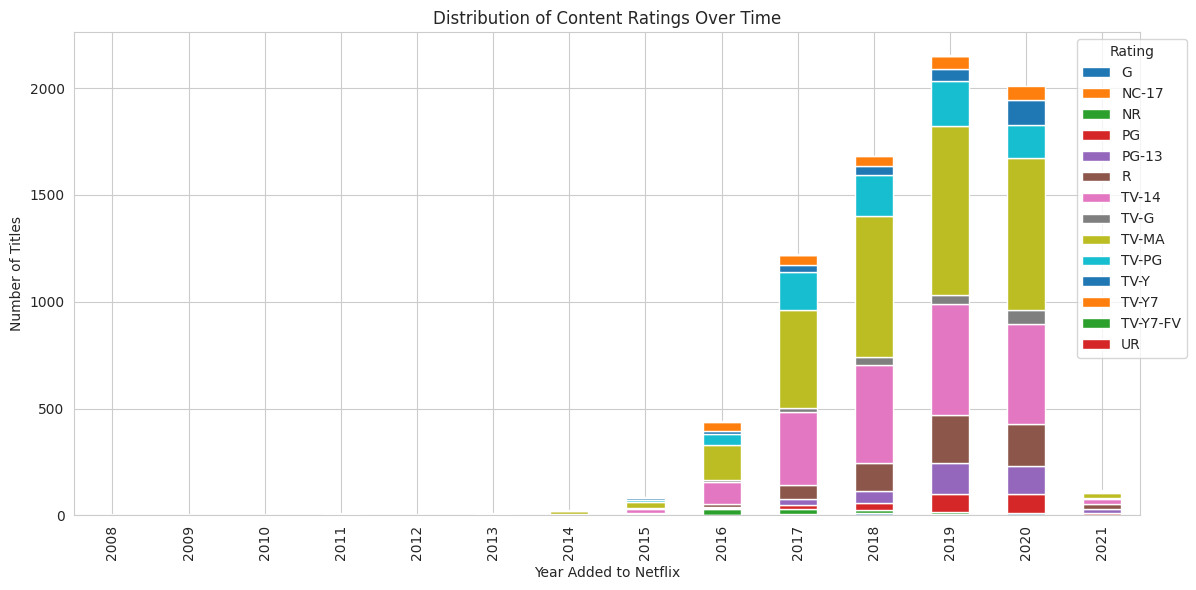

In [7]:
ratings_over_time = (
    netflix_df
    .groupby(['year_added', 'rating'])
    .size()
    .unstack(fill_value=0)
)

ratings_over_time.plot(
    kind='bar',
    stacked=True,
    figsize=(12, 6)
)

plt.title('Distribution of Content Ratings Over Time')
plt.xlabel('Year Added to Netflix')
plt.ylabel('Number of Titles')
plt.legend(title='Rating', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

Over time, Netflix’s content ratings have shifted strongly toward more mature audiences, with TV-MA and TV-14 titles increasing significantly, especially after 2016, while family-friendly ratings (G, PG, TV-G) remain relatively low and stable.

### Q2. Is there a relationship between content age and its type (Movie vs. TV Show)?

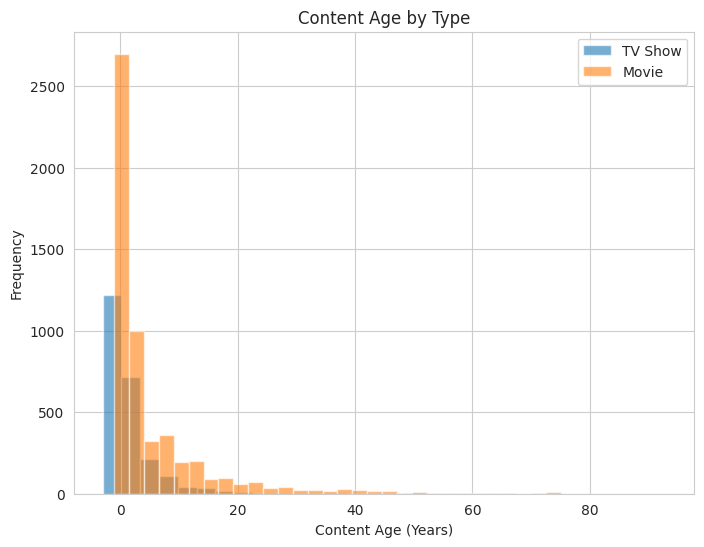

In [8]:
netflix_df['content_age'] = netflix_df['year_added'] - netflix_df['release_year']

plt.figure(figsize=(8, 6))

for content_type in netflix_df['type'].unique():
  subset = netflix_df[netflix_df['type'] == content_type]
  plt.hist(subset['content_age'], bins=30, alpha=0.6, label=content_type)

plt.title('Content Age by Type')
plt.xlabel('Content Age (Years)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

Yes, there is a clear relationship: TV shows are typically added to Netflix much closer to their release year, while movies show a wider and older age distribution, indicating that Netflix acquires older movies more often than TV shows.

### Q3. Can we identify any trends in content production based on the release year vs. the year added to Netflix?

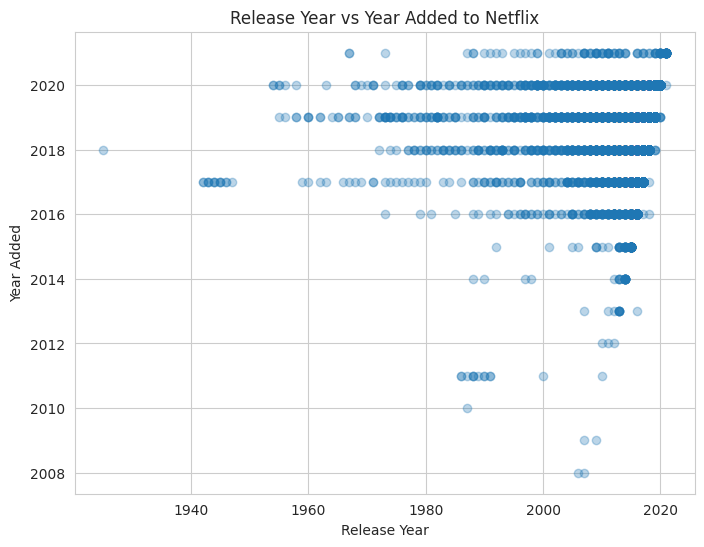

In [9]:
plt.figure(figsize=(8,6))

plt.scatter(
    netflix_df['release_year'],
    netflix_df['year_added'],
    alpha=0.3
)

plt.title('Release Year vs Year Added to Netflix')
plt.xlabel('Release Year')
plt.ylabel('Year Added')
plt.show()

Yes, the plot shows that recent releases are added to Netflix much more quickly, with many titles added in the same or following year, while older content tends to have a larger gap between release and addition, indicating a shift toward newer content over time.

### Q4. What are the most common word pairs or phrases in content descriptions?

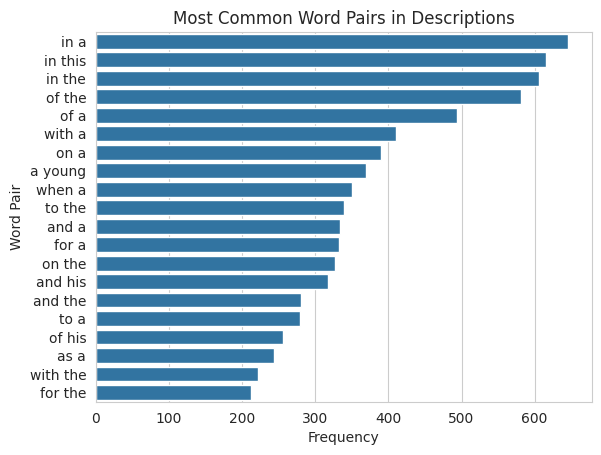

In [10]:
import re
from collections import Counter

def tokenize(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    words = text.split()
    return words

bigrams = []

for desc in netflix_df['description']:
    words = tokenize(desc)
    bigrams.extend(zip(words, words[1:]))

bigram_counts = Counter(bigrams)
top_bigrams = bigram_counts.most_common(20)

bigram_df = pd.DataFrame(
    top_bigrams, columns=['bigram', 'count']
)
bigram_df['bigram'] = bigram_df['bigram'].apply(lambda x: ' '.join(x))

sns.barplot(
    data=bigram_df,
    x='count',
    y='bigram'
)
plt.title("Most Common Word Pairs in Descriptions")
plt.xlabel("Frequency")
plt.ylabel("Word Pair")
plt.show()

The most common word pairs are generic connective phrases such as “in a,” “of the,” “with a,” and “on a,” indicating that Netflix descriptions rely heavily on standard narrative structures rather than highly specific repeated phrases.

### Q5. Who are the top directors on Netflix?

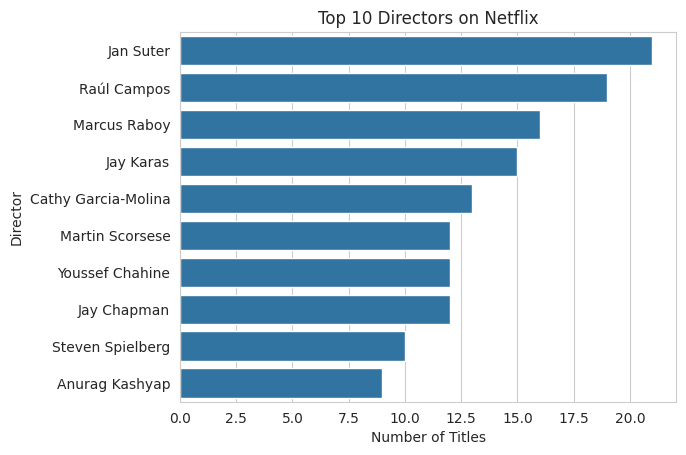

In [11]:
directors = (
    netflix_df['director']
    .dropna()
    .str.split(', ')
    .explode()
)

top_directors = directors[directors != 'Unknown'].value_counts().head(10)

sns.barplot(
    x=top_directors.values,
    y=top_directors.index
)
plt.title("Top 10 Directors on Netflix")
plt.xlabel("Number of Titles")
plt.ylabel("Director")
plt.show()

The plot shows that Jan Suter and Raúl Campos are the most prominent directors on Netflix by number of titles, followed by Marcus Raboy and Jay Karas.